# Making a Actor Classifier with VGG16

### Loading the VGG16 Model

In [1]:
ls /content/Actors.zip

/content/Actors.zip


In [2]:
!unzip Actors.zip

Archive:  Actors.zip
   creating: Actors/training_data/
   creating: Actors/training_data/Akshay_Kumar/
  inflating: Actors/training_data/Akshay_Kumar/a.jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (1).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (10).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (11).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (12).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (13).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (14).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (15).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (16).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (17).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (2).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (3).jpg  
  inflating: Actors/training_data/Akshay_Kumar/download (4).jpg  
  inflating: Actors/training_data/Akshay_

In [3]:
from keras.applications import VGG16

# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows = 224
img_cols = 224 

#Loads the VGG16 model 
model = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

Using TensorFlow backend.


58892288/58889256 [==============================] - 1s 0us/step


### Inpsecting each layer

In [4]:
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D True
2 Conv2D True
3 MaxPooling2D True
4 Conv2D True
5 Conv2D True
6 MaxPooling2D True
7 Conv2D True
8 Conv2D True
9 Conv2D True
10 MaxPooling2D True
11 Conv2D True
12 Conv2D True
13 Conv2D True
14 MaxPooling2D True
15 Conv2D True
16 Conv2D True
17 Conv2D True
18 MaxPooling2D True


### Let's freeze all layers except the top 4 

In [5]:
from keras.applications import VGG16

# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows = 224
img_cols = 224 

# Re-loads the VGG16 model without the top or FC layers
model = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


### Let's make a function that returns our FC Head

In [0]:
def addTopModel(bottom_model, num_classes, D=256):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

In [7]:
model.input

<tf.Tensor 'input_2:0' shape=(None, 224, 224, 3) dtype=float32>

In [8]:
model.layers

### Let's add our FC Head back onto VGG

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 4

FC_Head = addTopModel(model, num_classes)

modelnew = Model(inputs=model.input, outputs=FC_Head)

print(modelnew.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Loading our Actors Dataset

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/Actors/training_data'
validation_data_dir = '/content/Actors/validation_data'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 16
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 199 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


### Training our top layers

In [11]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
                   
checkpoint = ModelCheckpoint("actors_vgg.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# Note we use a very small learning rate 
modelnew.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 199
nb_validation_samples = 20
epochs = 3
batch_size = 16

history = modelnew.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

modelnew.save("actors_vgg.h5")

Epoch 1/3
12/12 [==============================] - 99s 8s/step - loss: 10.6454 - accuracy: 0.2623 - val_loss: 3.4842 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 3.48421, saving model to actors_vgg.h5
Epoch 2/3
12/12 [==============================] - 102s 9s/step - loss: 3.8397 - accuracy: 0.3333 - val_loss: 0.4582 - val_accuracy: 0.8000

Epoch 00002: val_loss improved from 3.48421 to 0.45823, saving model to actors_vgg.h5
Epoch 3/3
12/12 [==============================] - 98s 8s/step - loss: 1.7986 - accuracy: 0.3989 - val_loss: 0.2289 - val_accuracy: 0.9000

Epoch 00003: val_loss improved from 0.45823 to 0.22891, saving model to actors_vgg.h5


## Can we speed this up?
#### Let's try re-sizing the image to 64 x 64

In [12]:
from keras.applications import VGG16

# Setting the input size now to 64 x 64 pixel 
img_rows = 64
img_cols = 64 

# Re-loads the VGG16 model without the top or FC layers
vgg16 = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in vgg16.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


### Let's create our new model using an image size of 64 x 64

In [13]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/Actors/training_data'
validation_data_dir = '/content/Actors/validation_data'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 16
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Re-loads the VGG16 model without the top or FC layers
vgg16 = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Freeze layers
for layer in vgg16.layers:
    layer.trainable = False
    
# Number of classes in the Flowers-17 dataset
num_classes = 4

FC_Head = addTopModel(vgg16, num_classes)

model = Model(inputs=vgg16.input, outputs=FC_Head)

print(model.summary())

Found 199 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
____________________________________________

### Training using 64 x 64 image size is MUCH faster!

In [15]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
                   
checkpoint = ModelCheckpoint("actors_vgg_64.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# Note we use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.0001),
              metrics = ['accuracy'])

nb_train_samples = 199
nb_validation_samples = 20
epochs = 10
batch_size = 32

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

model.save("actors_vgg_64.h5")

Epoch 1/10
6/6 [==============================] - 6s 967ms/step - loss: 1.2679 - accuracy: 0.4598 - val_loss: 1.0776 - val_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 1.07756, saving model to actors_vgg_64.h5
Epoch 2/10
6/6 [==============================] - 5s 848ms/step - loss: 1.1460 - accuracy: 0.5312 - val_loss: 1.1235 - val_accuracy: 0.7000

Epoch 00002: val_loss did not improve from 1.07756
Epoch 3/10
6/6 [==============================] - 6s 1s/step - loss: 1.2302 - accuracy: 0.4896 - val_loss: 1.0401 - val_accuracy: 0.7500

Epoch 00003: val_loss improved from 1.07756 to 1.04011, saving model to actors_vgg_64.h5
Epoch 4/10
6/6 [==============================] - 5s 774ms/step - loss: 1.0535 - accuracy: 0.5402 - val_loss: 1.0034 - val_accuracy: 0.7500

Epoch 00004: val_loss improved from 1.04011 to 1.00341, saving model to actors_vgg_64.h5
Epoch 5/10
6/6 [==============================] - 6s 1s/step - loss: 1.0657 - accuracy: 0.5417 - val_loss: 1.0102 - val_accur

In [0]:
from keras.models import load_model

classifier = load_model('actors_vgg_64.h5')

Class - Salman_Khan


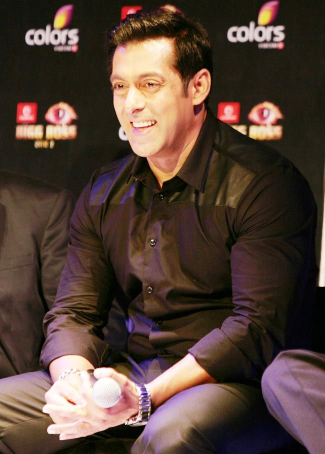

Class - Akshay_Kumar


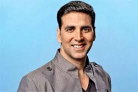

Class - Amitabh_Bacchan


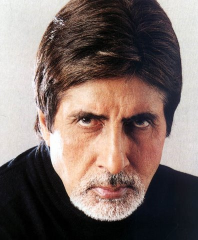

Class - Amitabh_Bacchan


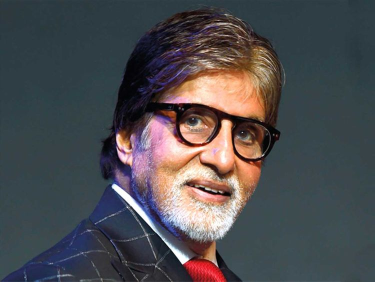

Class - Akshay_Kumar


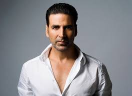

Class - Akshay_Kumar


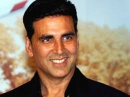

Class - Amitabh_Bacchan


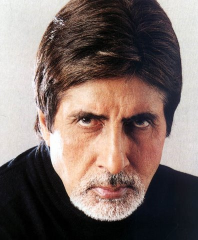

Class - Salman_Khan


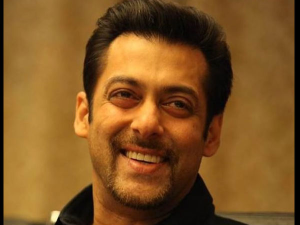

Class - Akshay_Kumar


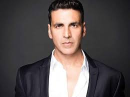

Class - Akshay_Kumar


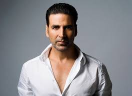

In [17]:
from IPython.display import clear_output
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from os import listdir
from os.path import isfile, join

Actors_dict = {"[0]": "Akshay_Kumar", 
                      "[1]": "Amitabh_Bacchan",
                      "[2]": "Ranbir_Kapoor",
                      "[3]": "Salman_Khan"}

Actors_dict_n = {"Akshay_Kumar": "Akshay_Kumar", 
                      "Amitabh_Bacchan": "Amitabh_Bacchan",
                      "Ranbir_Kapoor": "Ranbir_Kapoor",
                      "Salman_Khan": "Salman_Khan"}

def draw_test(name, pred, im):
    Actors = Actors_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, Actors, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + Actors_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage("/content/Actors/validation_data/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (64, 64), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,64,64,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    cv2_imshow(input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()